# AutoEncoder Example: MINST Fashion
A simple example/test the rudimentery AutoEncoder object recently added to the NeuralNets module. It uses the classic MNIST fashion data set: https://github.com/zalandoresearch/fashion-mnist, and tries to discover a 2-dimensional representation of the data.

In [1]:
# Imports
import sys
sys.path.append('../')
from BuildingBlocks import DenseBlock
from SimpleAutoEncoder import SimpleAutoEncoder
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Loading the fashion data set
(xtrain, ytrain), (xtest, ytest) = tf.keras.datasets.fashion_mnist.load_data()
# We don't need the data to be partitioned into training and test,
# so we may as well lump it all todether:
xcombined = np.concatenate([xtest,xtrain]) 
xflat = xcombined.reshape(xcombined.shape[0],784)
data = xflat/255 # It's numerically helpful to put the data into the range (0,1)

In [3]:
# If we wanted to evaluate the AE on just on article of clothing,
# Say sneakers (7) for instance:
#data = xflat[np.where(ytrain==7)[0],:]/255

### A quick check...
...we can do PCA on the data to get a rough estimate of the minimum number of latent dimensions that might be reasonable. What we see is that it's actually dominated by one pc, and definitely falls off after ~5. It certainly looks like 2 dimensions might be sufficient to capture the data.

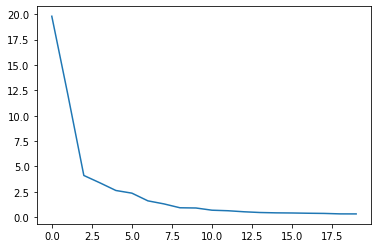

In [4]:
def principalcomponents(data):
    """quick and dirty pca, just recovering the component weights."""
    xbar = np.average(data, axis=0)
    B = data - np.ones(data.shape)*xbar
    C = np.dot(B.transpose(),B) / data.shape[0]
    u, v = np.linalg.eig(C)
    a = np.argsort(u)
    s = np.zeros(u.shape)
    for i in range(len(a)):
        s[-1-i] = u[a[i]]
    return s
s = principalcomponents(data)
plt.plot(s[:20])

### On training and archetecture,
After some trial and error in training the network, I've found a few things:

- **activation function choice:** Relu seems to produces a fuzzy grey images, while simoid creates a black blob that is nontheless the right shape.
- **latent dimensions**: Latent dimensions of 2, 12, 32, up to even 196, all seem to yeild basically identical results.
- **hidden archetecture**: The results seem a little better when the hidden layers have full rank (instead of tapering down to the latent dimensions). Other than that, the results are mostly insensitive to the specifics of the hidden arch.; adding more layers doesn't really improve the results after a ~2-3, and expanding the dims of the hidden layers to be larger than the input/output produces no noticible improvement.
- **two solutions**: In general, the network seems to converge to one of two solutions:
  - Blob - All latent variables decode into the exact same, blob that looks like the average of all the images. Effectively, the network just learns to invariably produce the average of the images.
  - Linear - The encoder learns to map all the images to a 1D subspace of the 2D latent space. These are the results we find below.
- **batch training**: It seems like the best training regime uses a small-ish batch size. Perhaps <0.01 of the training set. Smaller batch sizes tend to result in the 'linear' solution, while larger batch sizes lend themselves to the 'blob' solution. The downside, it seems, is that a small batch size can entirely miss certain catagories in the initial (high learning rate) stages, resulting in them being locked out.

In [5]:
block = DenseBlock([784, 784, 784], activation='sigmoid')
auto = SimpleAutoEncoder(784, 2, [block], latent_activation='sigmoid')
#auto.train(data, batch=10000, epochs=1)
auto.train(data, batch=100, epochs=20)

Epoch 1/20
700/700 [==============================] - 36s 49ms/step - loss: 0.4974 - accuracy: 0.0016
Epoch 2/20
700/700 [==============================] - 36s 51ms/step - loss: 0.4364 - accuracy: 0.0049
Epoch 3/20
700/700 [==============================] - 37s 53ms/step - loss: 0.3702 - accuracy: 0.0120
Epoch 4/20
700/700 [==============================] - 38s 55ms/step - loss: 0.3622 - accuracy: 0.0093
Epoch 5/20
700/700 [==============================] - 37s 53ms/step - loss: 0.3634 - accuracy: 0.0107
Epoch 6/20
700/700 [==============================] - 38s 54ms/step - loss: 0.3549 - accuracy: 0.0109
Epoch 7/20
700/700 [==============================] - 35s 51ms/step - loss: 0.3528 - accuracy: 0.0109
Epoch 8/20
700/700 [==============================] - 37s 53ms/step - loss: 0.3522 - accuracy: 0.0122
Epoch 9/20
700/700 [==============================] - 37s 52ms/step - loss: 0.3509 - accuracy: 0.0119
Epoch 10/20
700/700 [==============================] - 39s 56ms/step - loss: 0.351

### Visializing the results

In [6]:
# A function to draw up a given sample:
def draw(sample, ax):
    img = np.reshape(sample,(28,28))
    ax.imshow(img, cmap='Greys', interpolation='none')

#### Fig 1: An image from the set, next to the result of encoding/decoding that same image.
We'll select an image at random from the training data, then encode/decode it, and draw both side-by-side

In [7]:
# Either of these calls can be used to pass data through the full AE:
#transformed = auto.Decode(auto.Encode(data))
transformed = auto.autoencoder.predict(data)

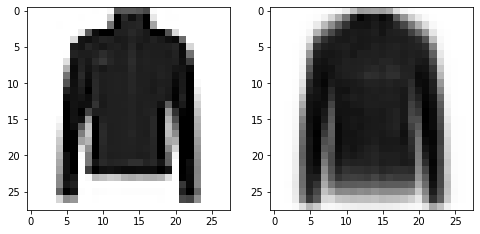

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
im = np.random.randint(0, data.shape[0])
draw(data[im,:], axes[0])
draw(transformed[im,:], axes[1])

#### Fig 2: Images resulting from randomly sampling the latent space.
Let's draw some random points in the latent space from a uniform distribution and see what kind of images they  decode into.

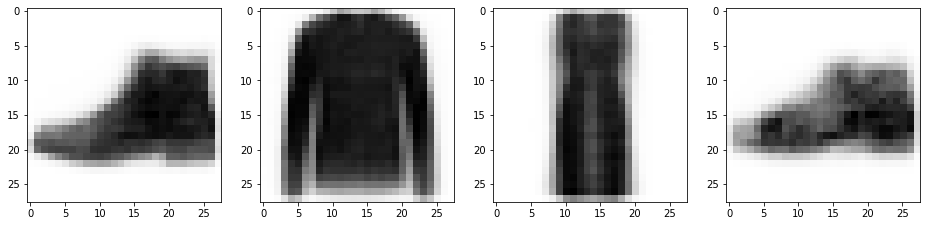

In [9]:
# The latent space should have values ~ 0-1
sample = np.random.rand(data.shape[0], auto.latentdims)
simg = auto.Decode(sample)
fig, axes = plt.subplots(1, 4, figsize=(16,4))
for i in range(4):
    im = np.random.randint(0, simg.shape[0])
    draw(simg[im,:], axes[i])

#### Fig 3: A visualization of the full decoder.
The entire point of making the latent space 2D was for easy visualization. Let's sample images from an array of latent space variables to get a sense of what the decoder is doing.

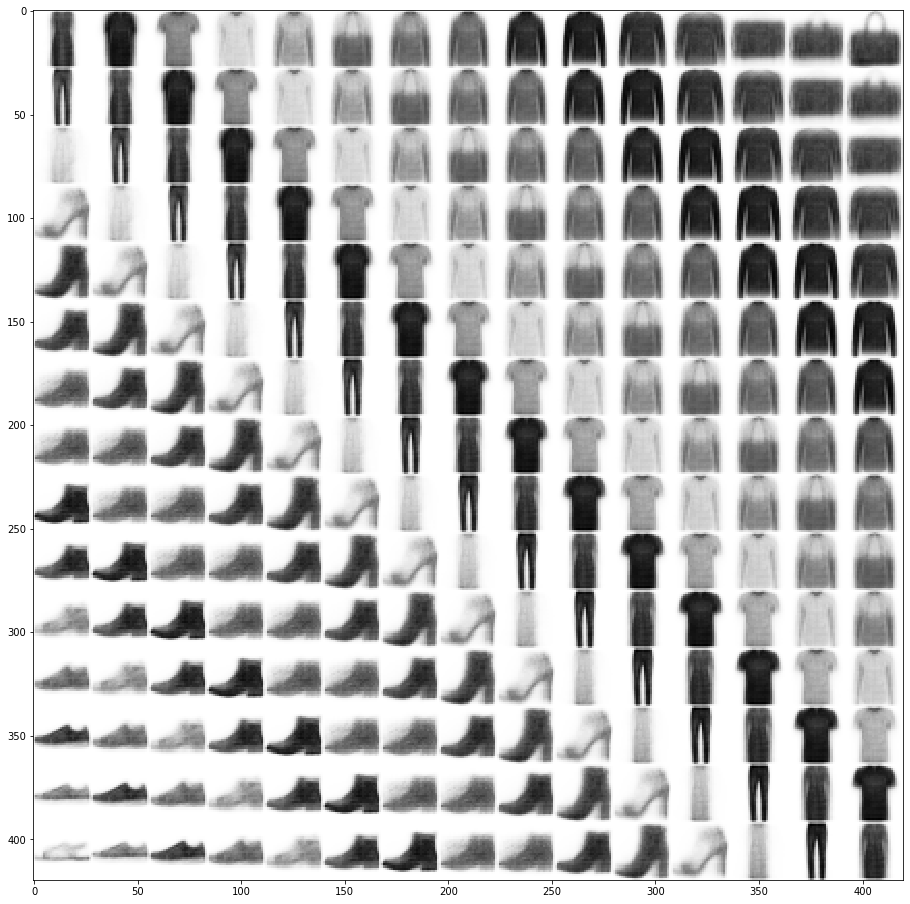

In [10]:
# Here is our spread of the results for a 2D sample space
nside = 15
x = np.linspace(0,1,num=nside)
x, y = np.meshgrid(x,x)
coords = np.array([x.flatten(), y.flatten()]).transpose()
simg = auto.Decode(coords)
image = np.zeros((28*nside,28*nside)); n=0
for i in range(nside):
    for j in range(nside):
        image[28*i:28*(i+1),28*j:28*(j+1)] = np.reshape(simg[n,:],(28,28))
        n += 1
fig, ax = plt.subplots(figsize=(16,16))
ax.imshow(image, cmap='Greys', interpolation='none')

Pretty neat, right? But: if you look at it long enough, you'll realize that the variation is not actually two dimensional --- see how the images are all the same along the diagonal?

#### Fig 4: The distribution of latent-space representations of images.
Finally, let's pass the training set through the encoder and scatter-plot their distributions in the latent space, to see how images are being clustered (or not)

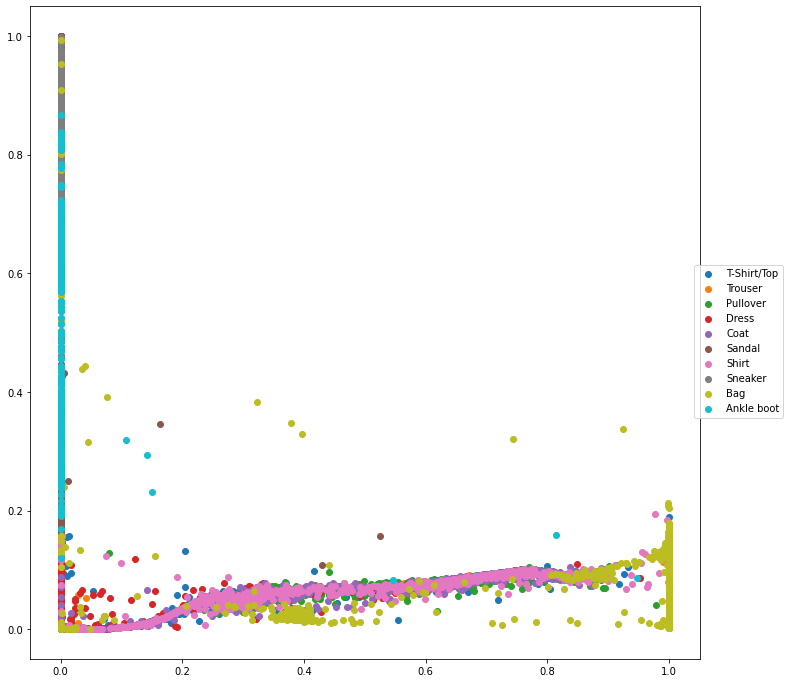

In [11]:
# To scatterplot the latent space distribution of different items
a = []
for i in range(10):
    a.append(auto.Encode(data[np.where(ytest==i)[0],:]))
a = np.array(a)
label_key = {0:"T-Shirt/Top",1:"Trouser",2:"Pullover",3:"Dress",4:"Coat",5:"Sandal",6:"Shirt",
    7:"Sneaker",8:"Bag",9:"Ankle boot"}
fig, ax = plt.subplots(figsize=(12,12))
for i in range(10):
    ax.scatter(a[i,:,0],a[i,:,1], label=label_key[i])
fig.legend(loc='right')

And here we confirm that the images are (more or less) getting mapped to a 1D subspace (i.e. a line) within the 2D latent space.

## Conclusions
Well, ultimately, I think what happened here is something that is commonly warned about in AE tutorials: the AE most likely just learned an approximation of the PCA decomposition, which would explain why when it worked it tended to find a 1D latent representation (the PCE shows the data set is dominated by 1 PC).

However, this is only the simplest possible iteration of an AutoEncoder, no convolution or variation or anything fancy, so it'll be interesting to see if those things improve upon the result.